# Importamos las librerias

### Manipulacion de DataFrame

In [0]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.preprocessing import LabelEncoder

### Manipulacion de DataFrame

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_importance

### Algoritmo

In [0]:
from xgboost import XGBRegressor

### Guardar, tiempo de procesamineto y versionado

In [0]:
import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)

# Importamos datos

In [0]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train_v2.csv')
test = pd.read_csv('test.csv').set_index('ID')

### Datos de entrenamiento

In [0]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


# Preparación de los datos

Uno de los principales ruidos que vamos a tener en este tipo de documentos es cifras desorbitadas de productos vendidos en un dia, precios disparados de productos y la duplicación de información.

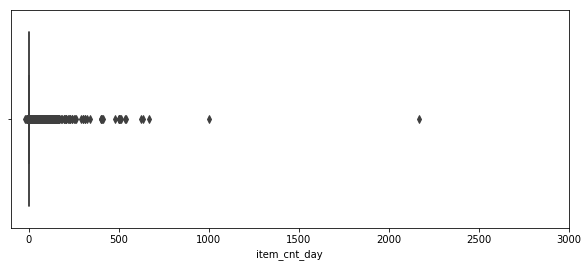

In [0]:
#Numero de productos vendidos en un mismo dia
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

In [0]:
Como vemos hay productos que en un dia se han vendido demasiado un dia y meten ruido al modelo que queremos entrenar

In [0]:
train.loc[train.item_cnt_day > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


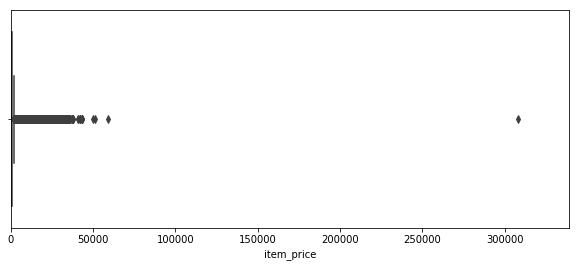

In [0]:
#Precio disparado de producto
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [0]:
train.loc[train.item_price > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [0]:
# Precios negativos de los productos
train.loc[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [0]:
# duplicado de información, en este caso en el id de las tiendas.
shops.loc[[57,1,58,10,11],:]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


In [0]:
# tambien podemos crear una funcion que nos seleccione los valores que esten por encima de un porcentaje de frecuencia de la columan selecionada
def filtrar_valores(datos, columna, porcentaje):
  columna_valores = datos.loc[:, columna].value_counts(normalize=True, sort=True)
  return list(columna_valores[columna_valores < porcentaje].index.sort_values(ascending=False))

filtrar_valores(train,'item_price',0.00002)

## Correción de los datos

### Outliers

In [0]:

train = train[train.item_price<300000]
train = train[train.item_cnt_day<1001]

### Datos negativos 

Lo corregimos con la media del valor del producto en ese mes

In [0]:
media = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = media

# Confirmamos que no hay mas valores negativos
train.loc[train.item_price < 0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Datos duplicados


In [0]:

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Codificamos las variables 
### Dataframe codificado shops

In [0]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [0]:
shops = shops[['shop_id','city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### Dataframe codificado cats

In [0]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# En esta funcion al explitear item_category_name y generar un tipo y un subtipo, hay filas en las que no hay subtipo, con lo cual dice
# que si el numero de letras del subtipo es < 1 que pille el tipo como subtipo
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [0]:
cats = cats[['item_category_id','type_code', 'subtype_code']]
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


### Dataframe Items

Eliminamos el nombre de cada producto porque no nos sirve para nada

In [0]:
items.drop(['item_name'], axis=1, inplace=True)

###  Datos a tener en cuenta

En muchos casos al hacer prediccion de la demanda con historico de datos hay que tener en cuenta  productos  nuevos, en el caso que vayan a apreciendo en nuestro set de entrenamiento, no nos molesta, el problema viene que entrenemos nuestro modelo y en los datos de test aparezcan nuevos.

In [0]:
len(list(set(test.item_id) - set(train.item_id)))

# En este caso aparecen 363 nuevos elementos en el set de datos de test que no estan en el set de entrenamiento.

363

# Creacion del dataframe de ventas por mes de cada producto

En el dataframe nos dan las ventas totales de cada producto por dia, como la prediccion se va hacer por mes, debemos calcular las vetas por mes

In [0]:
#Creamos la estructura de la matriz
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))


In [0]:
# Convertimos la matrix en dataframe pasandole la matrix y las cols que necesitamos para generar el dataframe
# Con la función vstack() unimos los arrays de cada 'date_block_num' que hemos creado (33)
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# Damos el formato a cada una de las columnas del dataframe

matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

In [0]:
matrix.sort_values(cols,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


### Calculamos las ventas de cada producto al dia, añadiendo una columna nueva a nuestro dataset de entrenamiento

In [0]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


## Group_by

In [0]:
# Hacemos un groupby por los campos a juntar y la operacion suma al numero de items que se han vendido
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})

# Colocamos nombre a ese nuevo campo creado
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
5,0,2,481,1.0
6,0,2,482,1.0
7,0,2,484,2.0
8,0,2,491,1.0
9,0,2,534,2.0


## Join

Tenemos que tener en cuenta que no tas las tiendas tienen todos los productos, por eso en el dataframe   `matrix` hemos creado todas las convinanciones existentes entre producto y tineda, es decir, ahora todas las tiendas tienen todos los productos.

Al hacer el join entre `matrix` y `group` los productos que no existian van a aparecer con valores Na, eso no es problema porque los pondremos a 0. Asi cuando calculemos las ventas del mes no influya ni produzca errorres

In [0]:
# Realizamos un join entre el dataframe matrix y el dataframe group
matrix = pd.merge(matrix, group, on=cols, how='left')

In [0]:
# Ponemos a 0 los valores Na que se han generado de los productos que no existian en las tiendas.
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).astype(np.float16)

## Analisis de los nuevos datos por mes


In [0]:
graph = matrix['item_cnt_month'].value_counts(normalize=True, sort=True)
graph = graph[:100,]
plt.figure(figsize=(50,5))
sns.barplot(graph.index, graph.values, alpha=1,ci= 2)
plt.xlabel('Numero de ventas', fontsize=12)
plt.ylabel('% apariciones en el data set', fontsize=12)
plt.show()

NameError: ignored

### Normalizacion de los datos

Como vemos en la gráfica la mayoria del data set se centra en los valores menores de 11..12... , en este caso no podemos borrar esos 'outliers' porque entonces borrariamos productos para un determinado mes y tienda, con lo cual no tiene sentido hacer eso. Aun asi si los mantenemos creara ruido para la predicción, con lo cual vamos a darle un valor maximo y minimo al data set. En este caso vamos a poner 20 

In [0]:
# Con la funcion clip() deja los valores que esten en el rango que le pases, y cambia los valores fuera de su rango, dando valor max y min
matrix['item_cnt_month2'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)

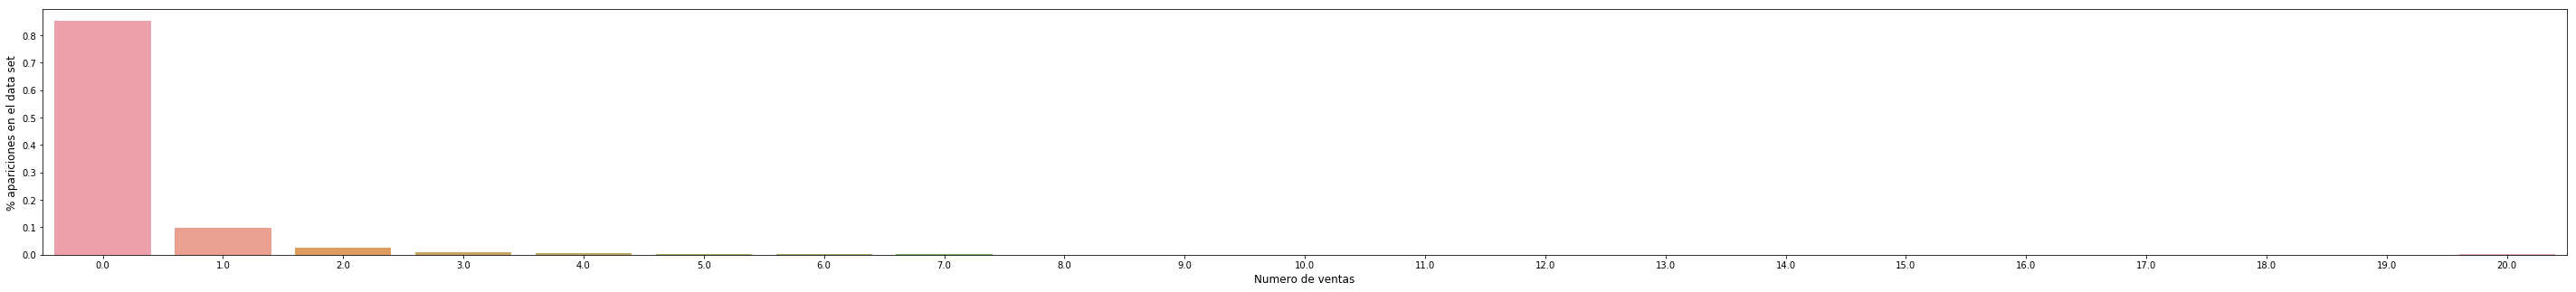

In [0]:

graph2 = matrix['item_cnt_month2'].value_counts(normalize=True, sort=True)
graph2 = graph2[:100,]
plt.figure(figsize=(50,5))
sns.barplot(graph2.index, graph2.values, alpha=0.9)
plt.xlabel('Numero de ventas', fontsize=12)
plt.ylabel('% apariciones en el data set', fontsize=12)
plt.show()

In [0]:
# Borramos la columna que nos hemos creado para la exploración

matrix = matrix.drop(['item_cnt_month'],axis=1)



In [0]:
# Renombramos columna
matrix = matrix.rename(columns = {'item_cnt_month2':'item_cnt_month'})
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


# Test

Procedemos a darle formato a la dataframe de test para que no nos salga ningun error de compatibilidad de formatos

In [0]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


Ahora hacemos un union de las dos matrices con la funcion concat, dandole los parametros 
`ignore_index = True ` para que cunado se produzca el union siga con la continuacion del index de la matriz madre y `keys =cols` para que coja como las columnas principales de la matriz madre en este caso cols.

In [0]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

In [0]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
5,0,2,33,1.0
6,0,2,34,0.0
7,0,2,35,0.0
8,0,2,40,0.0
9,0,2,41,0.0


# Union de todas las carecteristicas de las ventas.

Anteriormente hemos ido paso a paso trabajando cada uno de los datos que nos dieron:
* **sales_Train.csv** : Donde teniamos todos los datos de las ventas dia a dia, id_producto, numero de veces comprado en el dia y el precio del producto. El cual posteriormente lo tratamos para crear la mariz matrix donde recogiamos y creabamos todos los productos existentes en todas las tiendas, ademas de recoger las ventas de cada producto por mes!

* **Item_categories.csv** : En este docuemnto teniamos id de la categoria y el tipo de la categoria. Pero para este caso decidimos dividirlo en tipo y subtipo, el cual codificamos posteriormente.

* **items.csv** : nos relacionaba el nombre del articulo con su categoria, el cual codificamos para tenerlo todo en numeritos.

* **shops.csv** : hicimos en mismo proceso que las categorias, codificarlas y meterle una variable mas obtenida del name_shop.

* **Test.csv**: Lo hemos tratado para poder añadirlo a nuestra matriz madre.

Una vez tratados los datos procedimos a crearnos una matriz madre con todos los datos necesarios para el entrenamiento.



In [0]:
# Procedemos hacer los joins de los datos a la matriz madre

# Join shops
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
# Join item
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
# Join cats
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
# Les damos el formato a estas nuevas columnas
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)


In [0]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4
5,0,2,33,1.0,0,37,11,1
6,0,2,34,0.0,0,40,11,4
7,0,2,35,0.0,0,40,11,4
8,0,2,40,0.0,0,57,13,8
9,0,2,41,0.0,0,57,13,8


In [0]:
#### FUNCIONCITA QUE CREA UN CODIGO NUMERICO POR FRECUENCIA#########

def frec_encode(matriz, columna):
  frecuencia = matriz[columna].value_counts(normalize=True)
  frecuencia =frecuencia.to_frame().reset_index()
  frecuencia.columns =[columna ,'new']
  list_frec = (frecuencia.index).tolist()
  list_frec.sort(reverse = True)
  frecuencia['new'] = list_frec
  matriz = pd.merge(matriz, frecuencia, on=[columna], how='inner')
  matriz[columna] = matriz['new']
  matriz.drop(['new'], axis=1, inplace=True)
  return matriz



In [0]:
matrix = frec_encode(matrix,'city_code')
matrix = frec_encode(matrix,'type_code')
matrix = frec_encode(matrix,'subtype_code')

In [0]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,6,40,19,64
1,0,2,32,0.0,6,40,19,64
2,0,2,34,0.0,6,40,19,64
3,0,2,35,0.0,6,40,19,64
4,0,2,43,0.0,6,40,19,64
5,0,2,63,0.0,6,40,19,64
6,0,2,72,0.0,6,40,19,64
7,0,2,73,0.0,6,40,19,64
8,0,2,75,0.0,6,40,19,64
9,0,2,84,0.0,6,40,19,64


# Procedemos a añadirle el historico a los datos

Vamos a crear una funcion que le añada el historico de datos a nuestro dataframe. Elegimos los 3 ultimos meses anteriores, el 6 y el mes del año pasado, es decir el 12. Para ello hace un join entre las columnas principales por los meses elegidos del historico. Hay que tener en cuenta que en todos los los meses no esatn todos los productos, con los cual se generaran valores **Nan** en ciertos campos.

In [0]:
# Funcion

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy() # la funcion copy() copia en otra variable la matriz que le acompañe
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]  # Columns es una funcion que cambia el nombre de las columnas (no las borra ni crea nuevas)
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
  

## Agregados a partir del numero de productos vendidos al mes

In [0]:
# Generamos los nuevas columnas
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [0]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN
1,0,2,32,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN
2,0,2,34,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN
3,0,2,35,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN
4,0,2,43,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN


### Creamos agregado de la media del numero de  productos vendidos por mes



In [0]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

In [0]:
# Lo añadimos a nuestra matriz madre y le damos formato

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)

In [0]:
# le añadimos un historico a nuestros datos de la media de productos vendidos anteriormente
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')



In [0]:
# Eliminamos la columan de la media de los producto vendidos en ese mismo mes, porque no nos interesa tenerlo
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

### Creamos agregado de la media del numero de cada producto vendido por mes

In [0]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz madre el historico de la media de cada producto vendido por mes de los ultimos 3 meses, 6º mes y 12º mes
# y borramos la media de cada producto de ese mismo mes 
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [0]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12
0,0,2,19,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,32,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,34,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,35,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,43,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creamos el agregado de la media del numero de  productos venididos en cada tienda por mes

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico de los ultimos 3 meses, 6º mes y 12º mes
# y borramos el dato para ese mismo mes 
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

### Creamos el agregado de  la media del numero de  productos vendidos por categoria por mes

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [0]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1
0,0,2,19,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,32,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,34,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,35,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,43,0.0,6,40,19,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creamos agregado de la media del numero de  productos vendidos por categoria y tienda por mes

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes

matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

### Creamos agregado de la media del nunero de  productos vendidos por tienda y tipo de codigo por mes 

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

### Creamos agregado de la media del numero de  productos vendidos por tienda y subtipo de codigo por mes 

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

### Creamos agregado de la media del numero de  productos vendidos por codigo de ciudad y por  mes

In [0]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

### Creamos agregado de la media del numero de cada producto vendido por codigo de ciudad por mes

In [0]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)


### Creamos agregado de la media del numero de productos vendidos por tipo de coidgo

In [0]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

### Creamos agregado de la media del numero producto vendido por subtipo de coidgo

In [0]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)

In [0]:
# Añadimos a la matriz historico del ultimo mes
# y borramos el dato para ese mismo mes
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)


## Agregados a partir del precio del producto
### Agregado del porcentaje de variación de precio de los los ultimos 6 meses respecto al mes en el que nos encontremos

In [0]:
### Agregado de la media del precio por producto
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

### Agregado de la media del precio del producto por cada producto de cada mes 
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

### Creamos el Lag de los ultimos 6 meses 

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

### En este paso agregamos el porcentaje de las variaciones del precio del lag del precio de los ultimos 6 meses respecto a al mes inicial
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

## Borramos las columnas que no aportan valor como el valor medio de cada producto, y el lag del valor medio de cada producto por mes, ya que
## Lo hemos utilizado solo para calacular el porcentaje de la variacion del producto

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)


## Agregados a partir de las ventas del producto

### Creamos agregado de la suma de todas la ventas por tienda y mes

In [0]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

### Creamos la media de las ventas de cada tienda


In [0]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

### Creamos la variacion del porcentaje de la media de las ventas del mes pasado

In [0]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')
### Borramos las columnas que hemos creado para calcular la columna del lag
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

# Caracteristicas especiales
## Añadimos el numero de mes al que corresponde

Le añadimos el numero de mes que le corresponde a cada uno, es decir, el mes de enero corresponde a 0, pero en los datos del `date block` corresponde a 0,12,34 con lo cual creamos una variable `mes`

In [0]:
matrix['month'] = matrix['date_block_num'] % 12


In [0]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

### Meses desde la última venta 

In [0]:
## Por tienda y articulo
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num 

In [0]:
## Por articulo
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num 

### Meses desde la primera venta

In [0]:
## Por tienda y articulo
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

## Por articulo
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

# Retoque Final

Como estamos añadiendo historico en muchos de los casos de los meses 1,2,3,6,12 En los primeros meses del 2013 no tenemos ese historico, con lo cual tenemos Nan, asi que hay que elimanar los primeros 12 meses porque ese hisotirco ya aparecerá en el año 2014.

In [0]:
matrix = matrix[matrix.date_block_num > 11]

In [0]:
## Eliminar Nan de los Lags con la siguiente funcion

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

# Informacion de nuestra Matriz Final


In [0]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [0]:
matrix.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 27521 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int64
item_category_id                        int8
type_code                               int64
subtype_code                            int64
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12      

# Guardamos los datos

In [0]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# dejamos el test
gc.collect();

#  **Xgoost**

---

Cargamos los datos guardados y selecionamos las varibales deseadas para entrenar el algoritmo

In [0]:
import pandas as pd
import pickle
data = pd.read_pickle('data.pkl')


In [0]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale']]


data.sort_values(by = ['date_block_num'], inplace=True)

In [0]:
mat.sort_values(by=['date_shop_avg_item_cnt_lag_3'], ascending = False).head()

,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,delta_price_lag,month,days,item_shop_last_sale,item_last_sale,item_first_sale
date_shop_avg_item_cnt_lag_3,0.091531,0.125880,0.182335,0.250656,0.214723,0.181452,0.224545,0.009212,0.064147,0.129248,0.106921,0.093820,0.761762,1.000000,0.676122,0.505988,0.080461,0.305877,-0.041359,-0.101035,-0.018165,0.227055,-0.036339,0.146493
date_shop_avg_item_cnt_lag_2,0.117306,0.175647,0.244206,0.224755,0.202709,0.170361,0.275865,0.052233,0.117512,0.104832,0.091595,0.080201,1.000000,0.761762,0.619434,0.462551,0.101705,0.337203,-0.020941,-0.125289,-0.141706,0.200571,-0.040281,0.081230
date_shop_avg_item_cnt_lag_6,0.052983,0.066690,0.085738,0.109931,0.267530,0.211160,0.129548,-0.036689,-0.016534,0.008986,0.161333,0.129192,0.619434,0.676122,1.000000,0.621041,0.039892,0.240491,-0.092393,-0.043861,-0.040128,0.260532,-0.028206,0.299848
date_shop_avg_item_cnt_lag_12,0.029388,0.035319,0.045016,0.056267,0.097998,0.294142,0.068142,-0.048459,-0.037453,-0.024910,0.019813,0.216796,0.462551,0.505988,0.621041,1.000000,0.011082,0.172094,-0.096339,-0.008505,-0.000310,0.271486,-0.018671,0.451446
date_shop_cat_avg_item_cnt_lag_1,0.411802,0.506092,0.446968,0.419689,0.366498,0.295850,0.240223,0.412360,0.375632,0.352720,0.308735,0.252602,0.337203,0.305877,0.240491,0.172094,0.760856,1.000000,-0.034920,-0.051630,-0.003316,0.168851,0.014461,-0.016493


### Selecionamos los datos de entrenamiento (del mes 12 al 33 ),  los testear (mes 33).

In [0]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

In [0]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train),(X_valid,Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


In [0]:
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

from subprocess import check_output
from datetime import time


model = RandomForestRegressor(n_jobs=-1)
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, Y_train)
    scores.append(model.score(X_valid, Y_valid))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [0]:
model.score(X_train,Y_train)

0.31931006138904927